# Part 3: Sentiment Analysis

**Contesting Gender Equality? A Computational Analysis of Backlash in Gender-Related News Media**

A Semester Project by Julia Jensine Häfker

MSc. Business Data Science

Aalborg University

Hand In: 17.12.2026

# Set Up

## Necessary Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import torch
from pathlib import Path
from typing import Any, Dict, List, Optional
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

import json, re, os, warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/bertopic-clean/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
df_100k = pd.read_parquet("df_100k_pred.parquet")

# 5. Preparation for the analysis

## 5.1. Create df_gender

We now have the entire dataset labeled. For our further analysis, the not gender related articles are not relevant. We therefore first create a new dataframe called df_gender, which only contains gender related articles.

In [15]:
df_gender = df_100k[df_100k["lr_label"] == 1].copy()
print(len(df_gender))

10321


We can see that the new df_gender contains 10.321 rows, which aligns with the value count of gender related articles (in 4. EDA (gender)). 

To be 100% sure the extraction worked, we will check the unique values for labels.

In [46]:
df_gender["lr_label"].unique()

array([1])

We successfully created our target dataframe.

## 5.2. Export JSONL

As we will work with an LLM again we want to extract a JSONL.

In [ ]:
# export df_gender to JSONL
df_gender.to_json("df_gender.jsonl", orient="records", lines=True)

# 6. Zero-Shot Extraction of Sentiment

We now have a dataset which contains 100.000 gender related articles out of the dataset between 1980 and 2024. In these articles the sentiment towards gender related topics might differ. In a first step we want to extract the sentiment. 

We will extract the sentiment using a LLM.

## 6.1. Prompt for Extraction

You are an NLP classifier that analyzes newspaper texts discussing gender, sexuality, and social norms.

Assign two independent scores from 1 to 7:

1. Heteronormative sentiment
2. Sexist sentiment

Return only scores.

**Heteronormativity Classification**

Heteronormativity positions heterosexuality and a strict male–female binary as the normative basis of social life. It naturalizes binary gender, assumes heterosexual desire as default, and shapes institutions, discourse, knowledge production, and resource distribution.

Scoring (1–7)

1 → Explicitly anti-heteronormative; challenges binary/heterosexual norms.

2 → Challenges norms with minor implicit assumptions.

3 → Mostly neutral; little reinforcement.

4 → Subtle naturalization of heterosexuality or binary gender.

5 → Clear reinforcement of heterosexuality or binary gender as normative.

6 → Strong endorsement of heteronormative structures

7 → Highly pronounced heteronormativity; promotes heterosexuality and rigid binary as natural or correct.

**Sexism Classification (Ambivalent Sexism Theory)**

Sexism includes Hostile Sexism (HS)—openly negative attitudes toward women—and Benevolent Sexism (BS)—subjectively positive but paternalistic depictions (women as weak, pure, needing protection, or confined to restrictive roles).
Both HS and BS count fully as sexist.

Scoring (1–7)

1 → Explicitly anti-sexist; no HS/BS.

2 → Challenges sexism; minor implicit bias.

3 → Neutral/mixed; no explicit HS/BS.

4 → Subtle stereotyping.

5 → Clear BS or mild HS.

6 → Strong BS or explicit HS.

7 → Highly pronounced HS or BS; reinforces sexist ideology.

**Output Format**

Return only:

{
"heteronormativity_score": X,
"sexism_score": Y,
}

## 6.2. Comparison of models

LLMs differ in speed, tokens, and further parameters. To make the analysis as precise yet fast and effective as possible, the next part will compare the outcomes of different models. In the end, the best model will be chosen.

### 6.2.1 Load the LLM output

**Modell: GPT-oss 20b**

20.9B Parameters

Runtime total: 976.37

Runtime per article: 10,97 Sec./ article

In [4]:
# Load the file
with open("sentiment_classification_biggestmodel_thinking.json", "r", encoding="utf-8") as f:
    data = json.load(f)

rows = []

for item in data.get("results", []):
    # extract basic fields
    article_id = item.get("article_id")
    title = item.get("title")
    text = item.get("text")
    thinking = item.get("thinking")

    # parse content (a JSON string inside the JSON)
    content_raw = item.get("content", "{}")

    try:
        content = json.loads(content_raw)
    except:
        content = {}

    heteronorm = content.get("heteronormativity_score")
    sexism = content.get("sexism_score")

    rows.append({
        "article_id": article_id,
        "title": title,
        "text": text,
        "thinking": thinking,
        "heteronormativity_score": heteronorm,
        "sexism_score": sexism
    })

df_gpt = pd.DataFrame(rows)
df_gpt.head()

,article_id,title,text,thinking,heteronormativity_score,sexism_score
0,1796330,Beide haben die Verantwortung-betr.: dito,betr.: dito Von wegen: Väter bekommen kein Sor...,We need to read text in German. Summarize for ...,7,5
1,1783017,"""Das andere Geschlecht""","Betr.: „Hit des Tages“, taz vom 20.1.90 Wie sc...",We need to assess heteronormativity and sexism...,2,1
2,1764043,Ohne Mähne,betr.: „Angriffslustig und nicht unumstritten“...,"We need to analyze the snippet. The text: ""bet...",3,3
3,1779613,Utopie der Frauen-Selbsthilfe - und ihre Verhi...,Frauenpolitik wird im rot-grünen Senat zwar gr...,We need to classify heteronormativity and sexi...,3,2
4,1722251,Lehrstellen für Frauen,Dresden. Um der Benachteiligung von jungen Mäd...,We need to assign two scores. Let's analyze te...,3,1


In [5]:
df_gpt = df_gpt.rename(columns={"heteronormativity_score": "heteronormativity_gpt"})

df_gpt = df_gpt.rename(columns={"sexism_score": "sexism_gpt"})

df_gpt.head()

,article_id,title,text,thinking,heteronormativity_gpt,sexism_gpt
0,1796330,Beide haben die Verantwortung-betr.: dito,betr.: dito Von wegen: Väter bekommen kein Sor...,We need to read text in German. Summarize for ...,7,5
1,1783017,"""Das andere Geschlecht""","Betr.: „Hit des Tages“, taz vom 20.1.90 Wie sc...",We need to assess heteronormativity and sexism...,2,1
2,1764043,Ohne Mähne,betr.: „Angriffslustig und nicht unumstritten“...,"We need to analyze the snippet. The text: ""bet...",3,3
3,1779613,Utopie der Frauen-Selbsthilfe - und ihre Verhi...,Frauenpolitik wird im rot-grünen Senat zwar gr...,We need to classify heteronormativity and sexi...,3,2
4,1722251,Lehrstellen für Frauen,Dresden. Um der Benachteiligung von jungen Mäd...,We need to assign two scores. Let's analyze te...,3,1


**Modell: Ministral-3 14b**

13.9B Parameters

Runtime total: 202.72 Sec.

Runtime per article: 2,278 Sec./article

In [ ]:
with open("sentiment_classification_ministral14b.json", "r", encoding="utf-8") as f:
    data = json.load(f)

def clean_and_parse_content(raw):
    if raw is None:
        return {}

    # If it's already parsed JSON
    if isinstance(raw, dict):
        return raw

    # If it's not a string, give up safely
    if not isinstance(raw, str):
        return {}

    s = raw.strip()

    # Remove code fences if present
    s = re.sub(r"^\s*```(?:json)?\s*", "", s, flags=re.IGNORECASE)
    s = re.sub(r"\s*```\s*$", "", s)

    # Try direct JSON parse
    try:
        return json.loads(s)
    except Exception:
        pass

    # Fallback: extract the first JSON object {...} from the string
    m = re.search(r"\{.*\}", s, flags=re.DOTALL)
    if m:
        candidate = m.group(0).strip()
        try:
            return json.loads(candidate)
        except Exception:
            return {}

    return {}

rows = []
for item in data.get("results", []):
    content = clean_and_parse_content(item.get("content"))

    rows.append({
        "article_id": item.get("article_id"),
        "title": item.get("title"),
        "text": item.get("text"),
        "thinking": item.get("thinking"),
        "heteronormativity_score": content.get("heteronormativity_score"),
        "sexism_score": content.get("sexism_score"),
    })

df_ministral = pd.DataFrame(rows)

# optional: force numeric
df_ministral["heteronormativity_score"] = pd.to_numeric(df_ministral["heteronormativity_score"], errors="coerce")
df_ministral["sexism_score"] = pd.to_numeric(df_ministral["sexism_score"], errors="coerce")

df_ministral.head()


,article_id,title,text,thinking,heteronormativity_score,sexism_score
0,1796330,Beide haben die Verantwortung-betr.: dito,betr.: dito Von wegen: Väter bekommen kein Sor...,None,3,4
1,1783017,"""Das andere Geschlecht""","Betr.: „Hit des Tages“, taz vom 20.1.90 Wie sc...",None,1,6
2,1764043,Ohne Mähne,betr.: „Angriffslustig und nicht unumstritten“...,None,3,2
3,1779613,Utopie der Frauen-Selbsthilfe - und ihre Verhi...,Frauenpolitik wird im rot-grünen Senat zwar gr...,None,3,6
4,1722251,Lehrstellen für Frauen,Dresden. Um der Benachteiligung von jungen Mäd...,None,3,5


In [7]:
df_ministral = df_ministral.rename(columns={"heteronormativity_score": "heteronormativity_ministral"})

df_ministral = df_ministral.rename(columns={"sexism_score": "sexism_ministral"})

df_ministral.head()

,article_id,title,text,thinking,heteronormativity_ministral,sexism_ministral
0,1796330,Beide haben die Verantwortung-betr.: dito,betr.: dito Von wegen: Väter bekommen kein Sor...,None,3,4
1,1783017,"""Das andere Geschlecht""","Betr.: „Hit des Tages“, taz vom 20.1.90 Wie sc...",None,1,6
2,1764043,Ohne Mähne,betr.: „Angriffslustig und nicht unumstritten“...,None,3,2
3,1779613,Utopie der Frauen-Selbsthilfe - und ihre Verhi...,Frauenpolitik wird im rot-grünen Senat zwar gr...,None,3,6
4,1722251,Lehrstellen für Frauen,Dresden. Um der Benachteiligung von jungen Mäd...,None,3,5


### 6.2.2 Compare Results - Sexism

The following part will compare the agreement for sexism.

In [8]:
# Extract only the columns we need
df_s_gpt = df_gpt[["article_id", "sexism_gpt"]]
df_s_ministral = df_ministral[["article_id", "sexism_ministral"]]

# Merge them by article_id
df_sexism_compare = (
    df_s_gpt
    .merge(df_s_ministral, on="article_id", how="inner")
)

df_sexism_compare.head()

,article_id,sexism_gpt,sexism_ministral
0,1796330,5,4
1,1783017,1,6
2,1764043,3,2
3,1779613,2,6
4,1722251,1,5


In [9]:
df_sexism_compare[["sexism_gpt", "sexism_ministral"]].mean()

sexism_gpt          2.898876
sexism_ministral    3.932584
dtype: float64

In [11]:
# Pairwise agreement: GPT vs Ministral (heteronormativity)
agree_gpt_vs_ministral_sexism = (
    df_sexism_compare["sexism_gpt"]
    == df_sexism_compare["sexism_ministral"]
).mean()

print(
    "Agreement GPT vs Ministral (sexism):",
    round(agree_gpt_vs_ministral_sexism * 100, 2),
    "%"
)

Agreement GPT vs Ministral (sexism): 17.98 %


In [28]:
# Absolute difference between GPT and Ministral sexism scores
df_sexism_compare["diff_gpt_vs_ministral"] = (
    df_sexism_compare["sexism_gpt"] - df_sexism_compare["sexism_ministral"]
).abs()

# Summary statistics
df_sexism_compare[["diff_gpt_vs_ministral"]].describe()

,diff_gpt_vs_ministral
count,89.000000
mean,1.707865
std,1.399694
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5.000000


The differences are surprisingly big and it is unclear what the reason might be.

### 6.2.3. Compare Results - Heteronormativity

In [29]:
# Extract only the columns we need
df_h_gpt = df_gpt[["article_id", "heteronormativity_gpt"]]
df_h_ministral = df_ministral[["article_id", "heteronormativity_ministral"]]

# Merge them by article_id
df_hetero_compare = (
    df_h_gpt
    .merge(df_h_ministral, on="article_id", how="inner")
)

df_hetero_compare.head()

,article_id,heteronormativity_gpt,heteronormativity_ministral
0,1796330,7,3
1,1783017,2,1
2,1764043,3,3
3,1779613,3,3
4,1722251,3,3


In [33]:
df_hetero_compare[["heteronormativity_gpt", "heteronormativity_ministral"]].mean()

heteronormativity_gpt          3.382022
heteronormativity_ministral    3.213483
dtype: float64

In [34]:
# Pairwise agreement: GPT vs Ministral (heteronormativity)
agree_gpt_vs_ministral_hetero = (
    df_hetero_compare["heteronormativity_gpt"]
    == df_hetero_compare["heteronormativity_ministral"]
).mean()

print(
    "Agreement GPT vs Ministral (heteronormativity):",
    round(agree_gpt_vs_ministral_hetero * 100, 2),
    "%"
)

Agreement GPT vs Ministral (heteronormativity): 53.93 %


The results here are not as big as in the sexism category. It is - again - unsure what the reason might be.

To handel this discrepancy and make sure to choose the right model, there will be a human in the loop.

### 6.2.4. Human in the loop

Extract the 10 articles with the strongest disagreement for each sexism & heteronormativity.

In [38]:
# Compute absolute difference (if not already present)
df_sexism_compare["abs_diff"] = (
    df_sexism_compare["sexism_gpt"]
    - df_sexism_compare["sexism_ministral"]
).abs()

# Sort by largest disagreement and take top 20
df_top10_diff = (
    df_sexism_compare
    .sort_values("abs_diff", ascending=False)
    .head(10)
)

df_top10_diff

,article_id,sexism_gpt,sexism_ministral,diff_gpt_vs_ministral,abs_diff
14,1450886,1,6,5,5
67,5519656,2,7,5,5
1,1783017,1,6,5,5
12,1535054,1,6,5,5
30,1126800,1,6,5,5
63,5307423,7,2,5,5
17,1439911,3,7,4,4
3,1779613,2,6,4,4
4,1722251,1,5,4,4
34,809680,6,2,4,4


In 8 out of 10 cases, GPT is correct. In 1 out of 10 cases, Ministral is correct, and in one case, it is a tie.

In [39]:
# Compute absolute difference
df_hetero_compare["abs_diff"] = (
    df_hetero_compare["heteronormativity_gpt"]
    - df_hetero_compare["heteronormativity_ministral"]
).abs()

# Sort by largest disagreement and take top 20
df_top10_diff_hetero = (
    df_hetero_compare
    .sort_values("abs_diff", ascending=False)
    .head(10)
)

df_top10_diff_hetero

,article_id,heteronormativity_gpt,heteronormativity_ministral,abs_diff
63,5307423,7,1,6
50,700322,7,2,5
0,1796330,7,3,4
67,5519656,2,6,4
51,5154181,6,3,3
76,5681582,4,6,2
56,0439968,5,3,2
58,5069530,4,6,2
15,1428353,4,6,2
17,1439911,4,6,2


In 7 out of 10 cases, Ministral is correct, and in 3 out of 10 cases, GPT is correct.

### 6.2.5. Final Descision on the model & adjustments to the prompt

Over all the Ministral Model does not live up to the standards for this analysis and GPT is more reliable.

Following the human in the loop process there were some adjustments to the prompt:
1. The seven-point-scale was chosen to make sure the model can capture as much nuance as possible. After evaluating some of the data the conclusion is that a five-point-scale is sufficient and essentially improves the output quality and reliability.
2. The uneven number of points on the scale was chosen to have a neutral middle category. Currently the middle category is at three (out of seven), which is not analytically precise. This will be adapted.
2. To optimize the speed of the GPT Model the output will be kept to a minimum (no evident excerpt etc.)
3. To reduce errors from uncertainty a "I don't know"/ "999" category will be added.

**The final prompt:**

You are an NLP classifier that analyzes newspaper texts discussing gender, sexuality, and social norms.

Assign two independent scores from 1 to 5:

1. Heteronormative sentiment
2. Sexist sentiment (Ambivalent Sexism Theory)

If a dimension cannot be reliably assessed due to lack of relevant information or ambiguity, assign the value `999` instead of guessing.

*Heteronormativity Classification*

Heteronormativity frames heterosexuality and a strict male–female binary as the normative social order. It naturalizes binary gender, assumes heterosexual desire as default, and structures institutions, discourse, knowledge production, and resource distribution.

Scoring (1–5)

1 → Explicitly anti-heteronormative; actively challenges norms.

2 → Mostly critical of heteronormativity; minor residual assumptions.

3 → Neutral / descriptive; neither reinforcing nor challenging norms.

4 → Clear normalization of heterosexuality or binary gender.

5 → Explicit promotion of heterosexuality and rigid gender binary as natural or correct.

*Sexism Classification (Ambivalent Sexism Theory)*

Sexism includes both Hostile Sexism (HS) and Benevolent Sexism (BS).

Both forms count fully as sexist.

Scoring (1–5)

1 → Explicitly anti-sexist; actively rejects sexist assumptions.

2 → Mostly critical of sexism; minor implicit bias.

3 → Neutral / descriptive; no clear HS or BS present.

4 → Clear benevolent sexism or mild hostile sexism.

5 → Strong benevolent sexism or explicit hostile sexism.

Output Format:

Return only:

{
"heteronormativity_score": X,
"sexism_score": Y
}

Where `X` and `Y` are integers 1–5 or 999 (uncertain).

## 6.3. Sample for the LLM

To speed up the process, the data will be classified by the LLM in two parallel batches.

In [ ]:
# Optional: shuffle first to avoid ordering bias
df_shuffled = df_gender.sample(frac=1, random_state=42).reset_index(drop=True)

# Compute split index
mid = len(df_shuffled) // 2

# Split
df_gender_1 = df_shuffled.iloc[:mid].copy()
df_gender_2 = df_shuffled.iloc[mid:].copy()

print(len(df_gender_1), len(df_gender_2))

5160 5161


In [50]:
output_path = "sentiment_classification_df_gender_1.jsonl"

df_gender_1[
    ["article_id", "title", "text"]
].to_json(
    output_path,
    orient="records",
    lines=True,
    force_ascii=False
)

print("Exported to:", output_path)

Exported to: sentiment_classification_df_gender_1.jsonl


In [51]:
output_path = "sentiment_classification_df_gender_2.jsonl"

df_gender_2[
    ["article_id", "title", "text"]
].to_json(
    output_path,
    orient="records",
    lines=True,
    force_ascii=False
)

print("Exported to:", output_path)

Exported to: sentiment_classification_df_gender_2.jsonl


## 6.4. Import classified Sentiment

After the classification we now import sentiment back into the notebook.

In [ ]:
files = [
    "sentiment_batch_1_1.json",
    "sentiment_batch_1_2.json",
    "sentiment_batch_1_3.json",
    "sentiment_batch_1_4.json",
    "sentiment_batch_2_1.json",
    "sentiment_batch_2_2.json",
    "sentiment_batch_2_3.json",
    "sentiment_batch_2_4.json",
]

rows = []

for file in files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)

    for item in data.get("results", []):
        article_id = item.get("article_id")

        content_raw = item.get("content", "{}")
        try:
            content = json.loads(content_raw)
        except json.JSONDecodeError:
            content = {}

        rows.append({
            "article_id": article_id,
            "heteronormativity_score": content.get("heteronormativity_score"),
            "sexism_score": content.get("sexism_score"),
        })

df_scores = pd.DataFrame(rows)
df_scores.head()

,article_id,heteronormativity_score,sexism_score
0,1407830,3.0,3.0
1,1145519,3.0,3.0
2,0228500,3.0,3.0
3,5180848,5.0,3.0
4,1855871,3.0,3.0


In [13]:
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10321 entries, 0 to 10320
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   article_id               10321 non-null  object 
 1   heteronormativity_score  10316 non-null  float64
 2   sexism_score             10316 non-null  float64
dtypes: float64(2), object(1)
memory usage: 242.0+ KB


In [4]:
# merge based on matching article_id_norm
df_sentiment = df_100k.merge(
    df_scores,
    on="article_id",
    suffixes=("", "_sample")
)

df_sentiment.head()
print(len(df_sentiment))

10321


In [5]:
df_sentiment.head()

,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count,keywords_cleaned,length_chars,lr_label,lr_score,is_gender_related,heteronormativity_score,sexism_score
0,1875071,1986,I N T E R V I E W Aufbruch nach hinten,■ Motivationsprobleme der SPD nach Hamburg,"„Die SPD kann es schaffen, wenn sie auf Sieg s...",Jakob Sonnenschein,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",283,"[archiv, archiv, nachrichten, news, taz, tages...",1527,1,-0.002259,1,3.0,3.0
1,1878050,1986,Liberale Emanzipation,,"Gleichberechtigung von Frau und Mann, eine „ur...",taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",87,"[archiv, archiv, nachrichten, news, taz, tages...",435,1,-0.421646,1,3.0,3.0
2,1877119,1986,Für mehr Chancengleichheit,,"Goslar (dpa) - Der deutsche Frauenrat, ein Zus...",taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",98,"[archiv, archiv, nachrichten, news, taz, tages...",687,1,-0.433101,1,3.0,1.0
3,1877086,1986,„Huren–Kongreß“ im Parlament,■ Im Europarat protestiert eine fraktionsüberg...,Brüssel (taz) - Bereits im Vorfeld macht der 2...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",243,"[archiv, archiv, nachrichten, news, taz, tages...",1566,1,-0.206986,1,3.0,3.0
4,1877122,1986,Von der Koalitionsdebatte zum Wahlkampf,■ Die Grünen wollen Machtwechsel ohne eine Opt...,„Farbe bekennen“ war das Motto des Nürnberger ...,Ursel Sieber,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",645,"[archiv, archiv, nachrichten, news, taz, tages...",3691,1,-0.003874,1,3.0,3.0


# 7. Analysis of the Sentiment

Comments on the workflow can be found in the report.

## 7.1. Create general sentiment feature

### 7.1.1. Transforming 999 -> 0

Processing 999 will distort the output. We therefore transform it to "0".

In [7]:
df_sentiment[["heteronormativity_score", "sexism_score"]] = (
    df_sentiment[["heteronormativity_score", "sexism_score"]].replace(999, 0)
)

In [8]:
df_sentiment["heteronormativity_score"].unique(), df_sentiment["sexism_score"].unique()

(array([ 3.,  4.,  5.,  1.,  0.,  2., nan]),
 array([ 3.,  1.,  5.,  4.,  0.,  2., nan]))

### 7.1.2. Creating the new feature

Create the feature by calculating the mean. Further explanations in the report.

In [ ]:
# ensure numeric types
df_sentiment["sexism_score"] = pd.to_numeric(df_sentiment["sexism_score"], errors="coerce")
df_sentiment["heteronormativity_score"] = pd.to_numeric(df_sentiment["heteronormativity_score"], errors="coerce")

# compute mean sentiment (skip NaN if only one value exists)
df_sentiment["general_sentiment"] = df_sentiment[["sexism_score", "heteronormativity_score"]].mean(axis=1)

print(df_sentiment[["article_id", "sexism_score", "heteronormativity_score", "general_sentiment"]].head())

  article_id  sexism_score  heteronormativity_score  general_sentiment
0    1875071           3.0                      3.0                3.0
1    1878050           3.0                      3.0                3.0
2    1877119           1.0                      3.0                2.0
3    1877086           3.0                      3.0                3.0
4    1877122           3.0                      3.0                3.0


## 7.2 Qualitative Insights

To ensure quality a small qualitative analysi will be conducted. First for the worst scores, then for the best.

### 7.2.1. Worst Sentiment Score

In [24]:
N = 77
df_top_n = df_sentiment.nlargest(N, "general_sentiment")


In [25]:
df_top_n

,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count,keywords_cleaned,length_chars,lr_label,lr_score,is_gender_related,heteronormativity_score,sexism_score,general_sentiment
8,1877800,1986,Fruchtbare Juristen,,Berlin (taz) - Der 56. Deutsche Juristentag (D...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",211,"[archiv, archiv, nachrichten, news, taz, tages...",1327,1,-0.126131,1,5.0,5.0,5.0
17,1875984,1986,DAG gegen Bundeswehrfrauen,,Berlin (taz) - Der Dienst von Frauen an der Wa...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",71,"[archiv, archiv, nachrichten, news, taz, tages...",418,1,-0.135406,1,5.0,5.0,5.0
85,1828534,1988,"Das Unerklärliche, für das es lebenslänglich gibt","Ein Mordprozeß in Ansbach gegen drei Frauen, d...",Zu lebenslänglichen Gefängnisstrafen wurden di...,maria neef-uthoff,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",968,"[archiv, archiv, nachrichten, news, taz, tages...",5585,1,-0.034115,1,5.0,5.0,5.0
114,1844802,1988,Vom Nachttisch geräumt - Hinweise auf alte und...,"■ Hans Bisanz,Peter Altenberg: ""Mein äußerstes...","Peter Altenberg lebte in einem Hotelzimmer, da...",arno widmann,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",211,"[archiv, archiv, nachrichten, news, taz, tages...",1105,1,-0.081934,1,5.0,5.0,5.0
120,1923383,1988,Wer rettet die Kirche?,Großes Verderbnis durch Frauen im Priestergewa...,Angst vor Frauen im Priestergewand hat man(n) ...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",374,"[archiv, archiv, nachrichten, news, taz, tages...",2077,1,-0.332927,1,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,5530832,2018,Feminismus und bedrohte Männlichkeit?,,In vielen Beiträgen der letzten Tage konnte ma...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",139,"[archiv, archiv, nachrichten, news, taz, tages...",913,1,-0.115042,1,5.0,5.0,5.0
9031,5491300,2018,Die Wahrheit: Geil auf den Gesundheitsminister,Für Abtreibungsgegner wie Jens Spahn ist alles...,„Vielleicht schicke ich Jens Spahn eine Liebes...,Jacinta Nandi,True,"Frauenrechte, Jens Spahn, Wahrheit, Schwerpunk...","[Frauenrechte, Jens Spahn, Wahrheit, Schwerpun...",681,"[frauenrechte, jens spahn, wahrheit, schwerpun...",3564,1,-0.218209,1,5.0,5.0,5.0
9155,5573990,2019,crime scene: Dov Alfon und seine Lust an Super...,,Bekanntlich müssen in Israel alle jüdischen Bü...,Katharina Granzin,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",649,"[archiv, archiv, nachrichten, news, taz, tages...",3897,1,-0.018226,1,5.0,5.0,5.0
9390,5699058,2020,Diskussion über Frauen an der Macht: Brot für ...,"Warum wärmt es das Hirn, wenn man Gutes tut, M...","Sind Frauen bessere Menschen?“, fragt die Freu...",Jasmin Ramadan,True,"Beate Zschäpe, Frauen, Macht, Margaret Thatche...","[Beate Zschäpe, Frauen, Macht, Margaret Thatch...",663,"[beate zschäpe, frauen, macht, margaret thatch...",3201,1,-0.055185,1,5.0,5.0,5.0


### 7.2.2 Best Sentiment Score

In [28]:
N = 10

df_bottom_n = (
    df_sentiment[df_sentiment["general_sentiment"] >= 1]
    .nsmallest(N, "general_sentiment")
)

In [29]:
df_bottom_n

,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count,keywords_cleaned,length_chars,lr_label,lr_score,is_gender_related,heteronormativity_score,sexism_score,general_sentiment
140,1837041,1988,Für ein paar Tage eine neue Zeitung,"Von einem breiten Spektrum getragen, soll währ...","„Berlin, das ist deine Zeitung“, heißt der let...",wolfgang gast,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",733,"[archiv, archiv, nachrichten, news, taz, tages...",4673,1,-0.203717,1,1.0,1.0,1.0
161,1852766,1988,"■ Szene-Kalender: Tagung ""Soziale Projekte in ...",,Am 12. und 13. März veranstaltet der AK autono...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",162,"[archiv, archiv, nachrichten, news, taz, tages...",1125,1,-0.299684,1,1.0,1.0,1.0
182,1827557,1988,Frauen-Seminar,,In einem Seminar für Frauen in der Heimvolksho...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",75,"[archiv, archiv, nachrichten, news, taz, tages...",506,1,-0.255484,1,1.0,1.0,1.0
195,1854073,1988,§ 218: Widerstand gegen Überraschungscoup,,Wenn es nach dem Willen der Initiative „Frauen...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",126,"[archiv, archiv, nachrichten, news, taz, tages...",852,1,-0.316285,1,1.0,1.0,1.0
259,1822875,1989,Fußballstadion statt Frauenhaus,■ Radikale Sparpolitik zu Lasten der Frauen: D...,"Minus 41,5 Prozent. Diese radikale Kürzung der...",anette reimann,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",497,"[archiv, archiv, nachrichten, news, taz, tages...",3110,1,-0.327128,1,1.0,1.0,1.0
300,1809657,1989,„Frau des Wortes“,Auszüge aus dem Vorwort zu „Frausein allein is...,"Als mir Traute Hensch vorschlug, einen Teil me...",ingrid strobl,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",1383,"[archiv, archiv, nachrichten, news, taz, tages...",7935,1,-0.049544,1,1.0,1.0,1.0
340,1824210,1989,K O M M E N T A R Nicht einseifen lassen,"■ An den StudentInnen liegt es, ob das alles war",Alle haben gewonnen: Die StudentInnen haben ih...,susanne paas,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",179,"[archiv, archiv, nachrichten, news, taz, tages...",1172,1,-0.200372,1,1.0,1.0,1.0
367,1811377,1989,K O M M E N T A R Langschläfer,■ Feierabend-Gewerkschafter wollen Frau im Hau...,Abgehetzt stehe ich allzu oft am ach-so-kurzen...,birgitt rambalski,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",146,"[archiv, archiv, nachrichten, news, taz, tages...",954,1,-0.076744,1,1.0,1.0,1.0
391,1789310,1989,DDR-Aufbruch,,Journalismus in der DDR. Die erste Lüge eine V...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",79,"[archiv, archiv, nachrichten, news, taz, tages...",478,1,-0.018907,1,1.0,1.0,1.0
393,1820863,1989,Neue Antworten gesucht,■ Zeitschriften zu feministischer Theorie darf...,Nachdem die 'Feministischen Studien‘ 1986 ihr ...,birgit bosold,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",894,"[archiv, archiv, nachrichten, news, taz, tages...",5951,1,-0.451806,1,1.0,1.0,1.0


### 7.2.3. Extract further examples

In [ ]:
df_sentiment_examples = (
    df_sentiment
    .groupby("general_sentiment", group_keys=False)
    .apply(lambda x: x.sample(n=3, random_state=42))
)

As the transformation to csv cannot handle Umlaute, they are transformed here.

In [ ]:
df_sentiment_examples = df_sentiment_examples.copy()

replacements = {
    "ä": "ae",
    "ö": "oe",
    "ü": "ue",
    "Ä": "Ae",
    "Ö": "Oe",
    "Ü": "Ue",
    "ß": "ss"
}

df_sentiment_examples["text"] = (
    df_sentiment_examples["text"]
    .astype(str)
    .replace(replacements, regex=True)
)

Cleaning the columns before downloading.

In [ ]:
cols_to_drop = [
    "teaser",
    "contains_actors",
    "keywords_raw",
    "keywords",
    "token_count",
    "keywords_cleaned",
    "length_chars",
    "lr_label",
    "lr_score",
    "is_gender_related",
]

df_sentiment_examples = df_sentiment_examples.drop(columns=cols_to_drop, errors="ignore")

Downloading as csv.

In [ ]:
df_sentiment_examples.to_csv(
    "df_sentiment_examples.csv",
    index=False,
    encoding="utf-8"
)

## 7.3 Distribution of the Sentiment

### 7.3.1 Means

In [63]:
mean_heteronormativity = df_sentiment["heteronormativity_score"].mean()

mean_heteronormativity

2.8807677394338893

In [64]:
mean_sexism = df_sentiment["sexism_score"].mean()

mean_sexism

2.974117875145405

### 7.2.2 Counts of category

In [67]:
sexism_score_counts = (
    df_sentiment["sexism_score"]
    .value_counts()
    .sort_index()
    .reset_index()
)

sexism_score_counts.columns = ["sexism_score", "count"]
sexism_score_counts

,sexism_score,count
0,0.0,385
1,1.0,645
2,2.0,148
3,3.0,7366
4,4.0,1218
5,5.0,554


In [68]:
heteronorm_score_counts = (
    df_sentiment["heteronormativity_score"]
    .value_counts()
    .sort_index()
    .reset_index()
)

heteronorm_score_counts.columns = ["heteronormativity_score", "count"]
heteronorm_score_counts

,heteronormativity_score,count
0,0.0,510
1,1.0,397
2,2.0,308
3,3.0,7848
4,4.0,1104
5,5.0,149


In [34]:
sentiment_score_counts = (
    df_sentiment["general_sentiment"]
    .value_counts()
    .sort_index()
    .reset_index()
)

sentiment_score_counts.columns = ["general_sentiment", "count"]
sentiment_score_counts

,general_sentiment,count
0,0.0,378
1,0.5,11
2,1.0,178
3,1.5,185
4,2.0,628
5,2.5,253
6,3.0,6527
7,3.5,1123
8,4.0,697
9,4.5,259


### 7.2.3. Plots

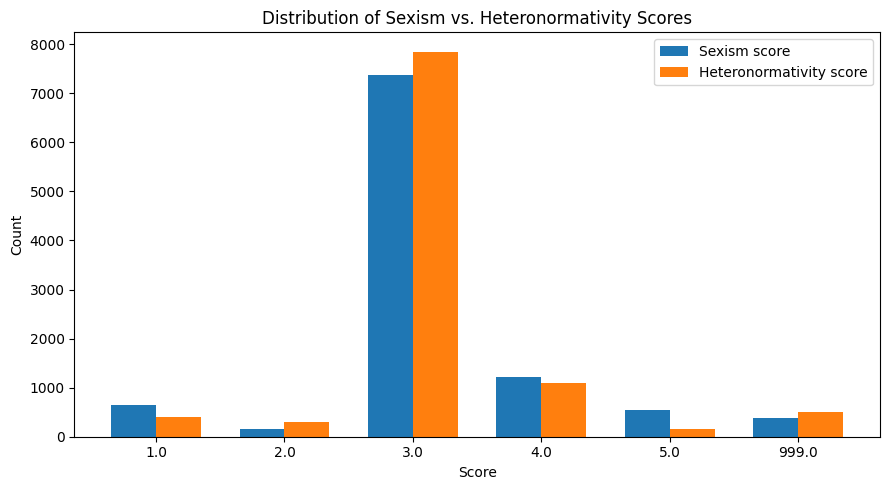

In [ ]:
# prepare data
scores = sorted(
    set(sexism_score_counts["sexism_score"])
    | set(heteronorm_score_counts["heteronormativity_score"])
)

sex_counts = sexism_score_counts.set_index("sexism_score").reindex(scores)["count"].fillna(0)
het_counts = heteronorm_score_counts.set_index("heteronormativity_score").reindex(scores)["count"].fillna(0)

x = np.arange(len(scores))
width = 0.35

# plot
plt.figure(figsize=(9, 5))
plt.bar(x - width/2, sex_counts, width, label="Sexism score")
plt.bar(x + width/2, het_counts, width, label="Heteronormativity score")

plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Distribution of Sexism vs. Heteronormativity Scores")
plt.xticks(x, [str(s) for s in scores])
plt.legend()

plt.tight_layout()
plt.show()

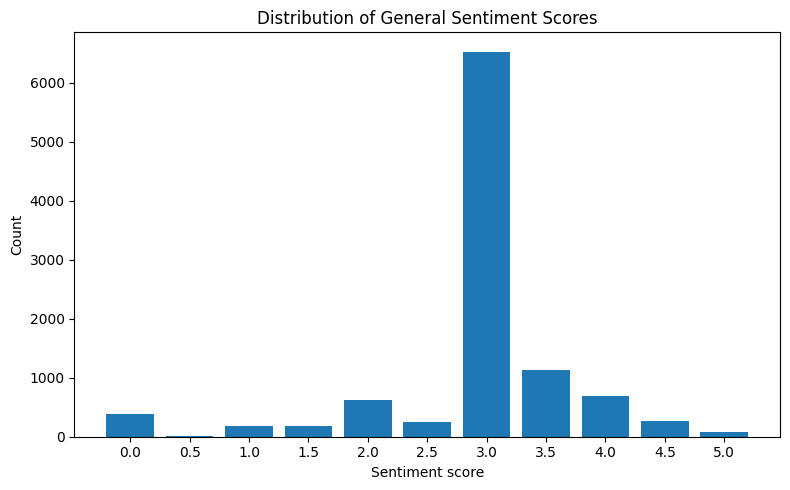

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(
    sentiment_score_counts["general_sentiment"].astype(str),
    sentiment_score_counts["count"]
)

plt.xlabel("Sentiment score")
plt.ylabel("Count")
plt.title("Distribution of General Sentiment Scores")

plt.tight_layout()
plt.show()

### 7.3.4 Sentiment over time

In [11]:
sentiment_by_year = (
    df_sentiment
    .groupby("year", as_index=False)["general_sentiment"]
    .mean()
)

In [12]:
heteronormativity_by_year = (
    df_sentiment
    .groupby("year", as_index=False)["heteronormativity_score"]
    .mean()
)

In [13]:
sexism_by_year = (
    df_sentiment
    .groupby("year", as_index=False)["sexism_score"]
    .mean()
)

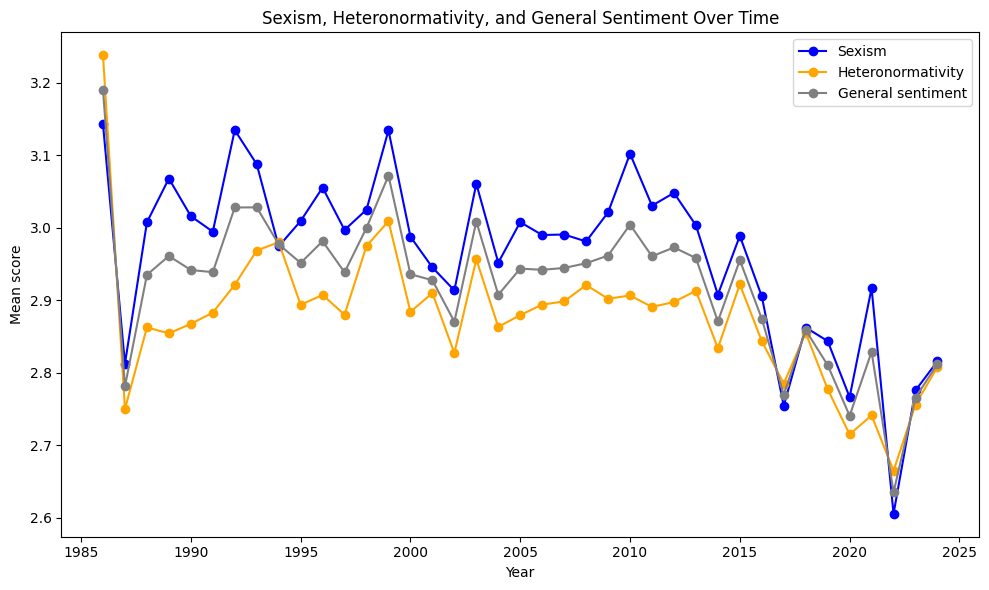

In [ ]:
plt.figure(figsize=(10, 6))

# Sexism (blue)
plt.plot(
    sexism_by_year["year"],
    sexism_by_year["sexism_score"],
    marker="o",
    color="blue",
    label="Sexism"
)

# Heteronormativity (orange)
plt.plot(
    heteronormativity_by_year["year"],
    heteronormativity_by_year["heteronormativity_score"],
    marker="o",
    color="orange",
    label="Heteronormativity"
)

# General sentiment (grey)
plt.plot(
    sentiment_by_year["year"],
    sentiment_by_year["general_sentiment"],
    marker="o",
    color="grey",
    label="General sentiment"
)

plt.xlabel("Year")
plt.ylabel("Mean score")
plt.title("Sexism, Heteronormativity, and General Sentiment Over Time")
plt.legend()

plt.tight_layout()
plt.show()


## 7.4. Regression

### 7.4.1. Years to general sentiment

In [17]:
# use yearly means (from previous step)
X = sentiment_by_year["year"]
y = sentiment_by_year["general_sentiment"]

X = sm.add_constant(X)  # adds intercept

model = sm.OLS(y, X).fit()

# extract stats
p_value = model.pvalues["year"]          # p-value for the year coefficient
r_squared = model.rsquared               # R²
r = np.sqrt(r_squared)                   # R (magnitude)
if model.params["year"] < 0:             # keep sign consistent with slope
    r = -r

# significance stars (common convention)
def sig_stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    if p < 0.1:   return "·"
    return "n.s."

# standard error of the year coefficient
std_error_year = model.bse["year"]

print("Regression: general_sentiment ~ year")
print(f"R      = {r:.3f}")
print(f"R²     = {r_squared:.3f}")
print(f"p      = {p_value:.6g} {sig_stars(p_value)}")
print(f"SE     = {std_error_year:.6f}")

Regression: general_sentiment ~ year
R      = -0.618
R²     = 0.382
p      = 2.79942e-05 ***
SE     = 0.001142


### 7.4.2. Years to heteronormative sentiment

In [18]:
heteronorm_by_year = (
    df_sentiment
    .groupby("year", as_index=False)["heteronormativity_score"]
    .mean()
)

In [ ]:
X = heteronorm_by_year["year"]
y = heteronorm_by_year["heteronormativity_score"]

X = sm.add_constant(X)

model_heteronorm = sm.OLS(y, X).fit()

# extract statistics
p_value = model_heteronorm.pvalues["year"]
r_squared = model_heteronorm.rsquared
r = np.sqrt(r_squared)
if model_heteronorm.params["year"] < 0:
    r = -r

# significance stars
def sig_stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    if p < 0.1:   return "·"
    return "n.s."

# standard error of the year coefficient
std_error_hetero = model_heteronorm.bse["year"]

print("Regression: heteronormativity_score ~ year")
print(f"R      = {r:.3f}")
print(f"R²     = {r_squared:.3f}")
print(f"p      = {p_value:.6g} {sig_stars(p_value)}")
print(f"SE     = {std_error_hetero:.6f}")

Regression: heteronormativity_score ~ year
R      = -0.548
R²     = 0.300
p      = 0.000303215 ***
SE     = 0.001150


### 7.4.3. Years to sexism sentiment

In [20]:
sexism_by_year = (
    df_sentiment
    .groupby("year", as_index=False)["sexism_score"]
    .mean()
)

In [22]:
X = sexism_by_year["year"]
y = sexism_by_year["sexism_score"]

X = sm.add_constant(X)

model_sexism = sm.OLS(y, X).fit()

# extract statistics
p_value = model_sexism.pvalues["year"]
r_squared = model_sexism.rsquared
r = np.sqrt(r_squared)
if model_sexism.params["year"] < 0:
    r = -r

# significance stars
def sig_stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    if p < 0.1:   return "·"
    return "n.s."

# standard error of the year coefficient
std_error_sexism = model_sexism.bse["year"]

print("Regression: sexism_score ~ year")
print(f"R      = {r:.3f}")
print(f"R²     = {r_squared:.3f}")
print(f"p      = {p_value:.6g} {sig_stars(p_value)}")
print(f"SE     = {std_error_sexism:.6f}")

Regression: sexism_score ~ year
R      = -0.619
R²     = 0.384
p      = 2.60984e-05 ***
SE     = 0.001318


### 7.4.4. Deep Dive: Last Decade

In [23]:
sentiment_10y = sentiment_by_year[
    (sentiment_by_year["year"] >= 2015) &
    (sentiment_by_year["year"] <= 2024)
].copy()

print("Years included:", sentiment_10y["year"].min(), "–", sentiment_10y["year"].max())
print("N years:", len(sentiment_10y))

Years included: 2015 – 2024
N years: 10


In [29]:
df = sentiment_by_year.copy()

df["post2015"] = (df["year"] >= 2015).astype(int)
df["year_c"] = df["year"] - df["year"].min()  # optional centering
df["interaction"] = df["year_c"] * df["post2015"]

X = df[["year_c", "post2015", "interaction"]]
X = sm.add_constant(X)
y = df["general_sentiment"]

model_10y = sm.OLS(y, X).fit()

# extract relevant statistics from interaction model
p_value = model_10y.pvalues["interaction"]
std_error = model_10y.bse["interaction"]
r_squared = model_10y.rsquared

# signed R (based on interaction effect)
r = np.sqrt(r_squared)
if model_10y.params["interaction"] < 0:
    r = -r

# significance stars
def sig_stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    if p < 0.1:   return "·"
    return "n.s."

# output
print("Regression: general_sentiment ~ year × post2015")
print(f"R      = {r:.3f}")
print(f"R²     = {r_squared:.3f}")
print(f"p      = {p_value:.6g} {sig_stars(p_value)}")
print(f"SE     = {std_error:.6f}")


Regression: general_sentiment ~ year × post2015
R      = -0.740
R²     = 0.548
p      = 0.0502151 ·
SE     = 0.007929
